In [10]:
# ─────────────────────────────────────────────────────────────
# TASK 1: EXPLORATORY DATA ANALYSIS (EDA) - News & Stock Data
# 10 Academy Week 1 - Predicting Price Moves with News Sentiment
# ─────────────────────────────────────────────────────────────

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from datetime import datetime
import os

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
%matplotlib inline

print("Task 1 EDA - All libraries loaded successfully!")

Task 1 EDA - All libraries loaded successfully!


In [11]:
# 1. Load the financial news dataset
news_path = "../data/news/raw_analyst_ratings.csv"
df_news = pd.read_csv(news_path)

print(f"News dataset loaded: {df_news.shape[0]:,} articles")
print(f"Date range: {df_news['date'].min()} → {df_news['date'].max()}")
df_news.head()

News dataset loaded: 1,407,328 articles
Date range: 2009-02-14 00:00:00 → 2020-06-11 17:12:35-04:00


,Unnamed: 0,headline,url,publisher,date,stock
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20-04:00,A
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 04:30:07-04:00,A
3,3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 12:45:06-04:00,A
4,4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 11:38:59-04:00,A


In [12]:
# 2. Basic info & cleaning
df_news.info()
df_news.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1407328 entries, 0 to 1407327
Data columns (total 6 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   Unnamed: 0  1407328 non-null  int64 
 1   headline    1407328 non-null  object
 2   url         1407328 non-null  object
 3   publisher   1407328 non-null  object
 4   date        1407328 non-null  object
 5   stock       1407328 non-null  object
dtypes: int64(1), object(5)
memory usage: 64.4+ MB


Unnamed: 0    0
headline      0
url           0
publisher     0
date          0
stock         0
dtype: int64

In [13]:
# Fix date column (some have time, some don't)
def parse_date(date_str):
    date_str = str(date_str).strip()
    formats = ["%Y-%m-%d %H:%M:%S", "%Y-%m-%d", "%Y-%m-%d %H:%M:%S%z"]
    for fmt in formats:
        try:
            return pd.to_datetime(date_str, format=fmt, utc=True)
        except:
            continue
    try:
        return pd.to_datetime(date_str)
    except:
        return pd.NaT

df_news['parsed_date'] = df_news['date'].apply(parse_date)
df_news = df_news.dropna(subset=['parsed_date'])
df_news['date_only'] = df_news['parsed_date'].dt.date
df_news['year_month'] = df_news['parsed_date'].dt.to_period('M')

print(f"Cleaned dataset: {len(df_news)} valid articles")


C:\Users\JERUSALEM\AppData\Local\Temp\ipykernel_37648\2354670096.py:18: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_news['year_month'] = df_news['parsed_date'].dt.to_period('M')


Cleaned dataset: 1407328 valid articles


TOP 10 MOST ACTIVE PUBLISHERS
publisher
Paul Quintaro        228373
Lisa Levin           186979
Benzinga Newsdesk    150484
Charles Gross         96732
Monica Gerson         82380
Eddie Staley          57254
Hal Lindon            49047
ETF Professor         28489
Juan Lopez            28438
Benzinga Staff        28114
Name: count, dtype: int64


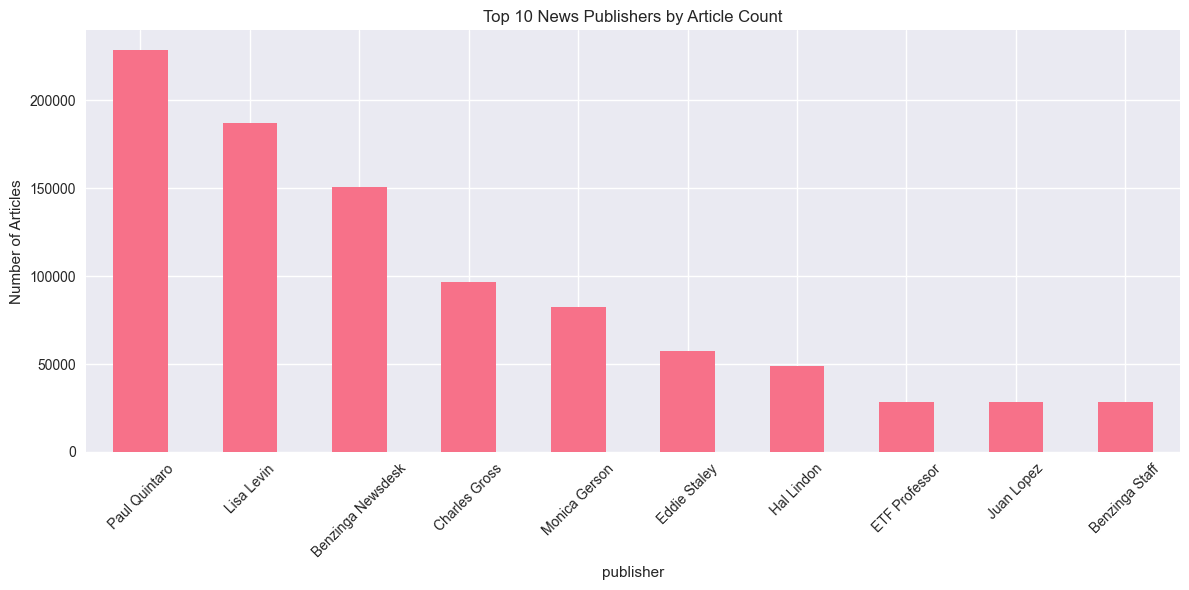

In [14]:
# 3. Descriptive Analysis
print("TOP 10 MOST ACTIVE PUBLISHERS")
publisher_counts = df_news['publisher'].value_counts().head(10)
print(publisher_counts)

plt.figure(figsize=(12, 6))
publisher_counts.plot(kind='bar')
plt.title('Top 10 News Publishers by Article Count')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

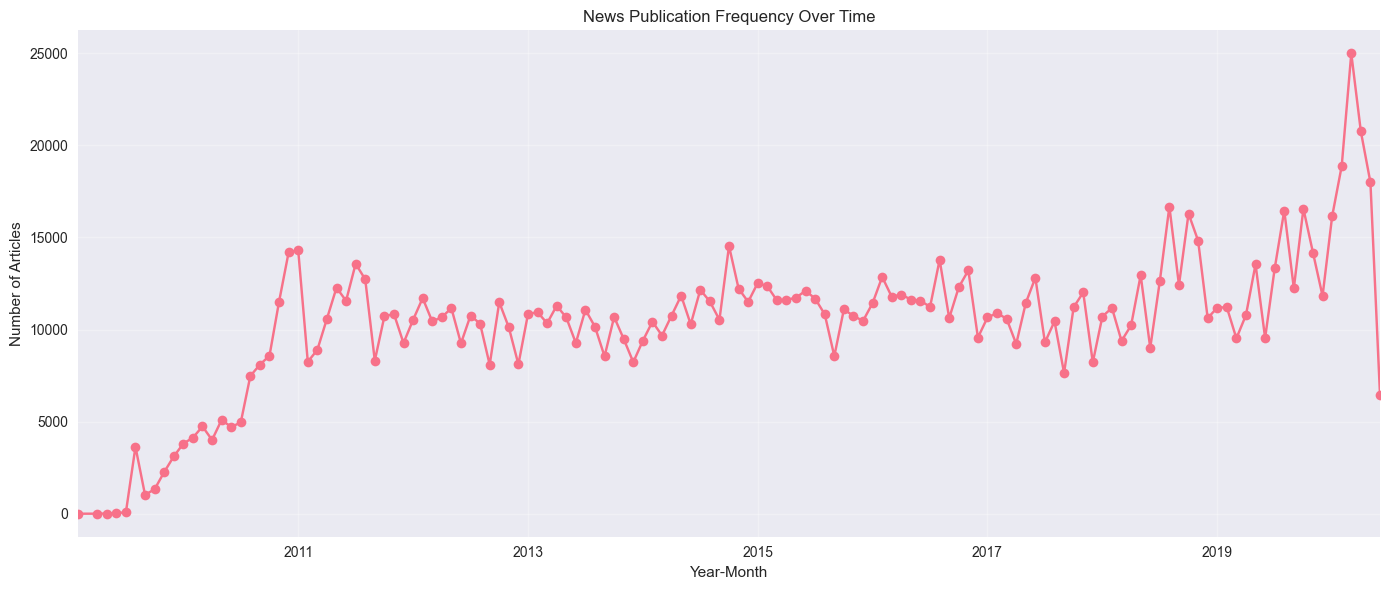

In [15]:
# 4. Publication Frequency Over Time
monthly_counts = df_news['year_month'].value_counts().sort_index()

plt.figure(figsize=(14, 6))
monthly_counts.plot(kind='line', marker='o')
plt.title('News Publication Frequency Over Time')
plt.ylabel('Number of Articles')
plt.xlabel('Year-Month')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

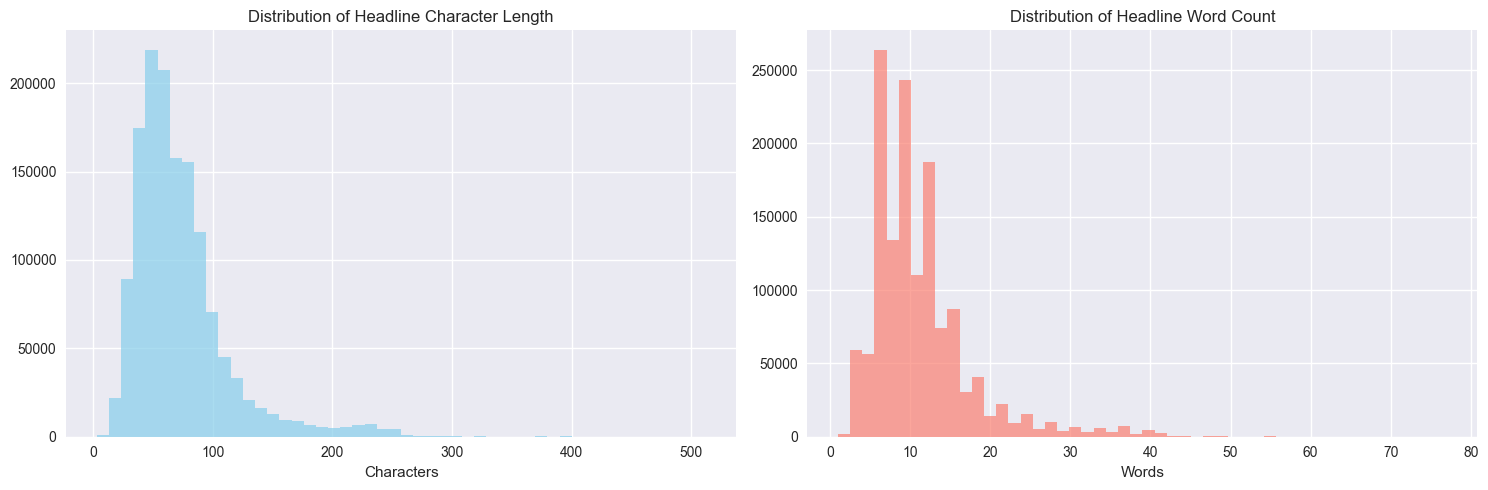

Average headline length: 73.1 characters
Average word count: 11.4 words


In [16]:
# 5. Headline Length Analysis
df_news['headline_length'] = df_news['headline'].str.len()
df_news['word_count'] = df_news['headline'].str.split().str.len()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.hist(df_news['headline_length'], bins=50, alpha=0.7, color='skyblue')
ax1.set_title('Distribution of Headline Character Length')
ax1.set_xlabel('Characters')

ax2.hist(df_news['word_count'], bins=50, alpha=0.7, color='salmon')
ax2.set_title('Distribution of Headline Word Count')
ax2.set_xlabel('Words')

plt.tight_layout()
plt.show()

print(f"Average headline length: {df_news['headline_length'].mean():.1f} characters")
print(f"Average word count: {df_news['word_count'].mean():.1f} words")

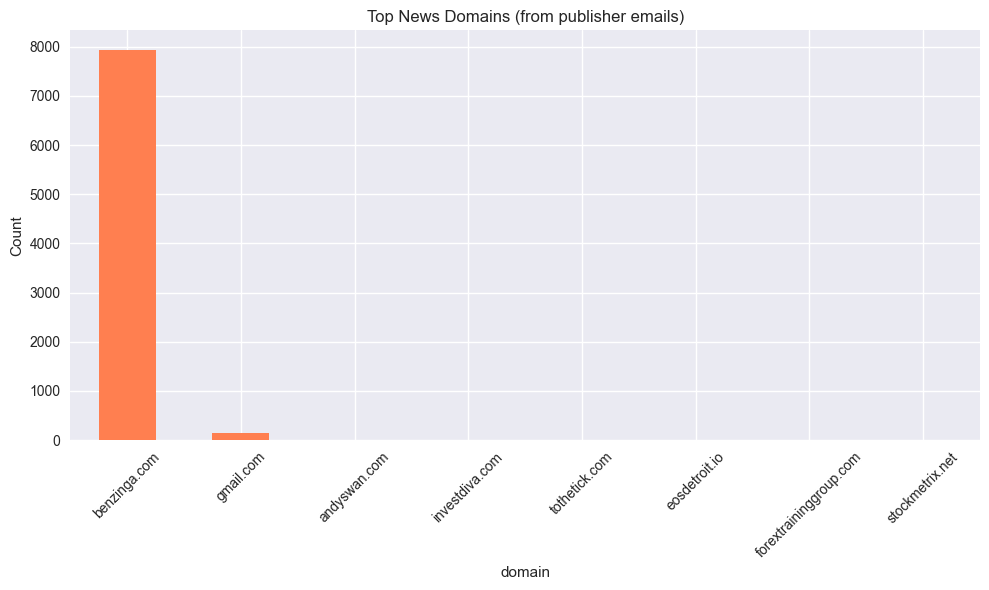

In [17]:
# 6. Most Common Domains (if email in publisher)
df_news['domain'] = df_news['publisher'].str.extract(r'@(.*)')
domain_counts = df_news['domain'].value_counts().head(10)

plt.figure(figsize=(10, 6))
domain_counts.plot(kind='bar', color='coral')
plt.title('Top News Domains (from publisher emails)')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Found 6 stock CSV files
AAPL data: 3774 rows from 2009-01-02 00:00:00 to 2023-12-29 00:00:00


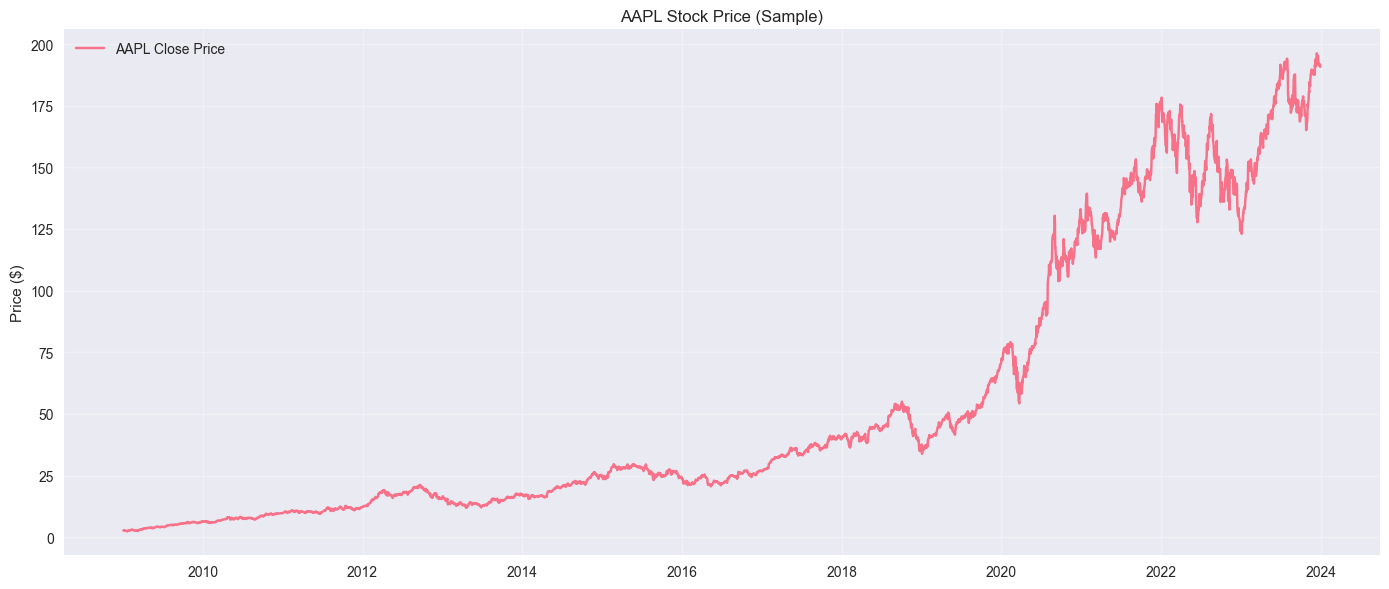

In [18]:
# 7. Sample stock price data (one example)
import os
import pandas as pd
import matplotlib.pyplot as plt

stock_files = os.listdir("../data/stocks/")
print(f"Found {len(stock_files)} stock CSV files")

# Load AAPL as example
aapl_path = "../data/stocks/AAPL.csv"
if os.path.exists(aapl_path):
    df_aapl = pd.read_csv(aapl_path, parse_dates=['Date'])
    print(f"AAPL data: {df_aapl.shape[0]} rows from {df_aapl['Date'].min()} to {df_aapl['Date'].max()}")
    
    plt.figure(figsize=(14, 6))
    plt.plot(df_aapl['Date'], df_aapl['Close'], label='AAPL Close Price')
    plt.title('AAPL Stock Price (Sample)')
    plt.ylabel('Price ($)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [20]:
# FINAL SUMMARY

required_vars = ['df_news', 'publisher_counts']
missing = [var for var in required_vars if var not in globals()]
if missing:
	raise NameError(f"Missing variables: {', '.join(missing)}. Please run all previous cells to load and process the news data.")

print("TASK 1 EDA COMPLETED SUCCESSFULLY")
print("="*60)
print(f"Total news articles analyzed: {len(df_news):,}")
print(f"Date range: {df_news['parsed_date'].min().date()} to {df_news['parsed_date'].max().date()}")
print(f"Number of unique publishers: {df_news['publisher'].nunique()}")
print(f"Most active publisher: {publisher_counts.index[0]} ({publisher_counts.iloc[0]:,} articles)")
print(f"Average headline length: {df_news['headline_length'].mean():.1f} chars")
print("All visualizations generated")
print("Ready for Task 2 (Quantitative) and Task 3 (Sentiment Correlation)")
print("="*60)

TASK 1 EDA COMPLETED SUCCESSFULLY
Total news articles analyzed: 1,407,328
Date range: 2009-02-14 to 2020-06-11
Number of unique publishers: 1034
Most active publisher: Paul Quintaro (228,373 articles)
Average headline length: 73.1 chars
All visualizations generated
Ready for Task 2 (Quantitative) and Task 3 (Sentiment Correlation)
